In [99]:
import tweepy
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [100]:
config = pd.read_csv("./config.csv")

In [101]:
# Twitter API config
twitterApiKey = config['twitterApiKey'][0]
twitterApiSecret = config['twitterApiSecret'][0]
twitterApiAccessToken = config['twitterApiAccessToken'][0]
twitterApiAccessTokenSecret = config['twitterApiAccessTokenSecret'][0]

In [102]:
# Authenticate
auth = tweepy.OAuthHandler(twitterApiKey, twitterApiSecret)
auth.set_access_token(twitterApiAccessToken, twitterApiAccessTokenSecret)
twitterApi = tweepy.API(auth, wait_on_rate_limit = True)

In [103]:
# キーワードからツイートを取得
tweets = tweepy.Cursor(twitterApi.search,  
                        count=1000,
                        q='COVID',
                        exclude_replies=True,
                        lang = 'en',
                        since='2021-06-27',
                        until='2021-06-28'
                        ).items(1000);


In [104]:
df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweet'])
df.head(1000)

,Tweet
0,RT @monteskw: Previous CJI Hon'ble Legand Shri...
1,Anti-vaxxer mistakes pub beer tent for Covid t...
2,RT @BrianMitchellMP: So why was the Treasurer ...
3,RT @RealMattCouch: The average age of death fr...
4,RT @shark_mendy: @VizagRailways @MP_MvvOfficia...
...,...
995,RT @SaludAmerica: Meet these real Latinos who:...
996,RT @kensleyanne: Every single athlete who made...
997,RT @angie_rasmussen: This is a huge story. An ...
998,"RT @TheArcofMass: On June 29, learn about comp..."


In [105]:
# Cleaning the tweets

def cleanUpTweet(txt):
    # Remove mentions
    txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
    # Remove hashtags
    txt = re.sub(r'#', '', txt)
    # Remove retweets:
    txt = re.sub(r'RT : ', '', txt)
    # Remove urls
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
    return txt

In [106]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader_analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zxxxs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [107]:
def getTextPolarity(txt):
    return vader_analyzer.polarity_scores(txt)
def getTextPos(txt):
    return txt.get("pos")
def getTextNeu(txt):
    return txt.get("neu")
def getTextNeg(txt):
    return txt.get("neg")
def getTextCom(txt):
    return txt.get("compound")

def getTextAnalysis(l):
    s = l.get("compound")
    if s < 0:
        return "Negative"
    elif s == 0:
        return "Neutral"
    else:
        return "Positive"

In [108]:
df['Score'] = df['Tweet'].apply(getTextPolarity)
df['neg'] = df['Score'].apply(getTextNeg)
df['neu'] = df['Score'].apply(getTextNeu)
df['pos'] = df['Score'].apply(getTextPos)
df['compound'] = df['Score'].apply(getTextCom)
df['Sentiment'] = df['Score'].apply(getTextAnalysis)

In [109]:
df.drop(columns='Score')

,Tweet,neg,neu,pos,compound,Sentiment
0,RT @monteskw: Previous CJI Hon'ble Legand Shri...,0.000,0.891,0.109,0.4019,Positive
1,Anti-vaxxer mistakes pub beer tent for Covid t...,0.143,0.857,0.000,-0.3612,Negative
2,RT @BrianMitchellMP: So why was the Treasurer ...,0.108,0.692,0.200,0.3400,Positive
3,RT @RealMattCouch: The average age of death fr...,0.120,0.735,0.145,0.1280,Positive
4,RT @shark_mendy: @VizagRailways @MP_MvvOfficia...,0.000,1.000,0.000,0.0000,Neutral
...,...,...,...,...,...,...
995,RT @SaludAmerica: Meet these real Latinos who:...,0.199,0.686,0.116,-0.3182,Negative
996,RT @kensleyanne: Every single athlete who made...,0.068,0.932,0.000,-0.1695,Negative
997,RT @angie_rasmussen: This is a huge story. An ...,0.205,0.709,0.086,-0.4939,Negative
998,"RT @TheArcofMass: On June 29, learn about comp...",0.000,1.000,0.000,0.0000,Neutral


In [110]:
df.to_csv("COVID_sentiment_vader.csv")

In [111]:
positive = df[df['Sentiment'] == 'Positive']
neutral = df[df['Sentiment'] == 'Neutral']
negative = df[df['Sentiment'] == 'Negative']

print(str(positive.shape[0]/(df.shape[0])*100) + " % of positive tweets")
print(str(neutral.shape[0]/(df.shape[0])*100) + " % of neutral tweets")
print(str(negative.shape[0]/(df.shape[0])*100) + " % of negative tweets")

34.699999999999996 % of positive tweets
25.6 % of neutral tweets
39.7 % of negative tweets


<BarContainer object of 3 artists>

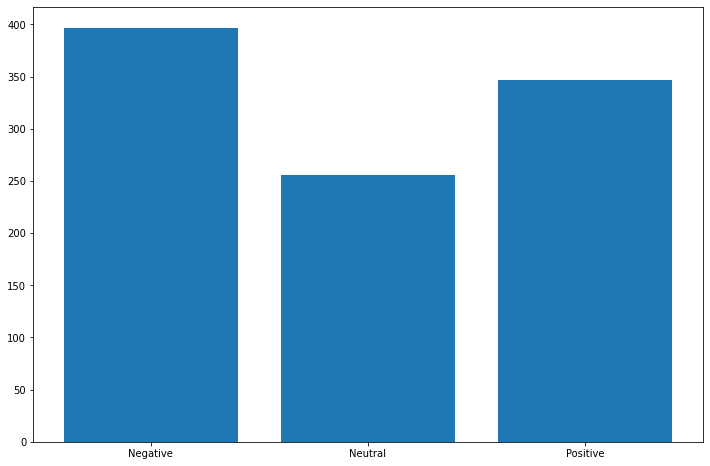

In [112]:
labels = df.groupby('Sentiment').count().index.values

values = df.groupby('Sentiment').size().values

plt.bar(labels, values)